In [1]:
# 掛載 Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 下載&解壓縮資料集
!pip install --upgrade gdown
import gdown
import shutil

def download_from_drive():
  url = "https://drive.google.com/drive/folders/1pvJ78rJzzbphMyNJfWH4FSgAidYXcd7d?usp=drive_link"
  gdown.download_folder(url, quiet=True, use_cookies=False)
  shutil.move('./fabric_data/TKU_CV.zip', './drive/MyDrive/fabric_image_recognition')
  !unzip ./drive/MyDrive/fabric_image_recognition/TKU_CV.zip -d ./drive/MyDrive/fabric_image_recognition

download_from_drive()

Archive:  ./drive/MyDrive/fabric_image_recognition/TKU_CV.zip
   creating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_10.bmp  
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_11.bmp  
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_12.bmp  
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_13.bmp  
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_14.bmp  
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_15.bmp  
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_16.bmp  
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_17.bmp  
  inflating: ./drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_18.bmp 

In [3]:
# 匯入必要的函式庫
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [4]:
# 設定參數
data_dir = pathlib.Path('./drive/MyDrive/fabric_image_recognition/TKU_CV')
batch_size = 32
img_height = 180
img_width = 180
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
# 手動平衡數據集並分割
def create_balanced_dataset():
  class_names = sorted(['NG_Horizontal', 'NG_Spot', 'NG_Vertical', 'OK_Fabric'])
  class_files = {cls: list((data_dir / cls).glob('*.bmp')) for cls in class_names}

  # 計算類別權重
  class_counts = [len(files) for files in class_files.values()]
  total_samples = sum(class_counts)
  class_weights = {i: total_samples/(len(class_names)*count) for i, count in enumerate(class_counts)}

  # 分割訓練集和驗證集
  train_ds = []
  val_ds = []
  for cls_idx, (cls, files) in enumerate(class_files.items()):
    split = int(0.8 * len(files))
    train_files = files[:split]
    val_files = files[split:]

    # 對NG_Spot類別進行過採樣
    if cls == 'NG_Spot':
      repeat_factor = len(files) // split + 10 # 增加重複次數
      train_files *= repeat_factor

    train_ds.extend([(str(f), cls_idx) for f in train_files])
    val_ds.extend([(str(f), cls_idx) for f in val_files])

  # 創建TensorFlow Dataset
  def prepare_dataset(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    return img, label

  train_ds = tf.data.Dataset.from_tensor_slices((np.array([x[0] for x in train_ds]), np.array([x[1] for x in train_ds])))
  train_ds = train_ds.map(prepare_dataset, num_parallel_calls=AUTOTUNE)
  train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

  val_ds = tf.data.Dataset.from_tensor_slices((np.array([x[0] for x in val_ds]), np.array([x[1] for x in val_ds])))
  val_ds = val_ds.map(prepare_dataset, num_parallel_calls=AUTOTUNE)
  val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

  return train_ds, val_ds, class_weights

train_ds, val_ds, class_weights = create_balanced_dataset()

In [12]:
# 資料增強
data_augmentation = models.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  # layers.RandomRotation(0.3),
  # layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
  layers.GaussianNoise(0.1)
])

In [13]:
# 模型架構
def create_model():
  model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4)
  ])

  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
  )
  return model

model = create_model()

# 訓練參數
early_stop = callbacks.EarlyStopping(
  monitor='val_loss',
  patience=15,
  restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
  './drive/MyDrive/fabric_image_recognition/best_model.h5',
  save_best_only=True,
  monitor='val_loss'
)

In [16]:
# 訓練模型
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  class_weight=class_weights,
  callbacks=[early_stop, checkpoint]
)

# 保存最終模型
model.save("./drive/MyDrive/fabric_image_recognition/trained_model.h5")

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9922 - loss: 0.0166 - val_accuracy: 0.9539 - val_loss: 0.2472
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9539 - val_loss: 0.2560
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9982 - loss: 0.0047

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.9982 - loss: 0.0048 - val_accuracy: 0.9671 - val_loss: 0.2359
Epoch 4/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9945 - loss: 0.0088

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9948 - loss: 0.0086 - val_accuracy: 0.9605 - val_loss: 0.2301
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9474 - val_loss: 0.2581
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9474 - val_loss: 0.2452
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9605 - val_loss: 0.2376
Epoch 8/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0033

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.9998 - loss: 0.0034 - val_accuracy: 0.9737 - val_loss: 0.2249
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9925 - loss: 0.0137 - val_accuracy: 0.9408 - val_loss: 0.3039
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9993 - loss: 0.0065 - val_accuracy: 0.9671 - val_loss: 0.2271
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9605 - val_loss: 0.2343
Epoch 12/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0032

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9803 - val_loss: 0.2158
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9605 - val_loss: 0.2347
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9737 - val_loss: 0.2221
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9671 - val_loss: 0.2205
Epoch 16/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9950 - loss: 0.0055 - val_accuracy: 0.9539 - val_loss: 0.2430
Epoch 17/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9991 - loss: 0.0024

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9989 - loss: 0.0026 - val_accuracy: 0.9671 - val_loss: 0.2149
Epoch 18/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9671 - val_loss: 0.2248
Epoch 19/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9737 - val_loss: 0.2279
Epoch 20/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9671 - val_loss: 0.2271
Epoch 21/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9918 - loss: 0.0165 - val_accuracy: 0.9474 - val_loss: 0.2993
Epoch 22/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9977 - loss: 0.0101 - val_accuracy: 0.9671 - val_loss: 0.2484
Epoch 23/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9474 - val_loss: 0.2624
Epoch 24/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.967

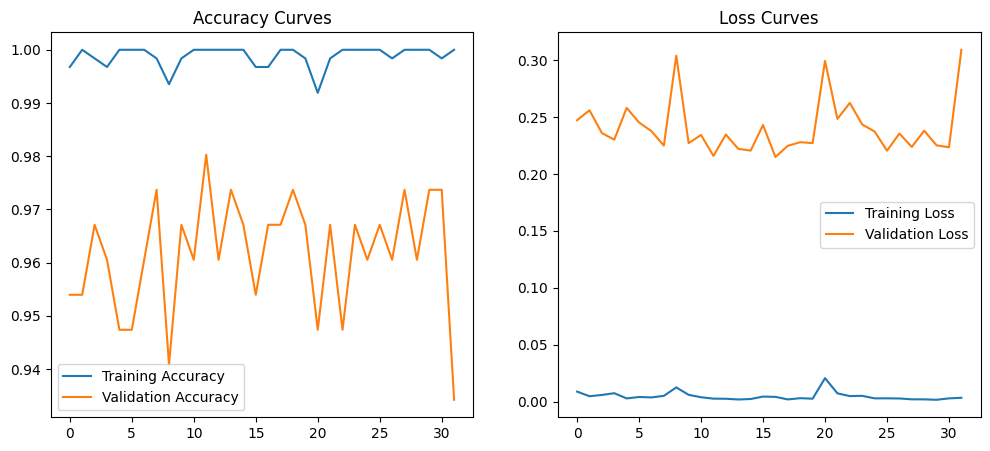

In [17]:
# 可視化訓練過程
def plot_training(history):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Curves')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Curves')
  plt.legend()

  plt.savefig('./drive/MyDrive/fabric_image_recognition/training_curves.png')
  plt.show()

plot_training(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


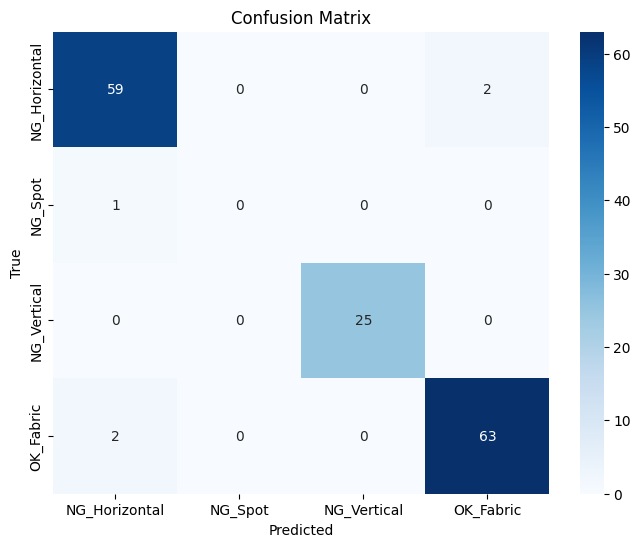

In [18]:
# 產生混淆矩陣
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset):
  true_labels = []
  pred_labels = []

  for images, labels in dataset:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    pred_labels.extend(preds.numpy())

  cm = confusion_matrix(true_labels, pred_labels)
  plt.figure(figsize=(8,6))
  class_names = sorted(['NG_Horizontal', 'NG_Spot', 'NG_Vertical', 'OK_Fabric'])
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.savefig('/content/drive/MyDrive/fabric_image_recognition/confusion_matrix.png')
  plt.show()

plot_confusion_matrix(model, val_ds)